In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:
!nvidia-smi


Thu Feb 20 15:18:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd


file_path = "/content/TD.csv"

df = pd.read_csv(file_path)
df.head()


,Unnamed: 0,src,tgt
0,1,"After passing tenth, someone will give you her...",दस ले पास है जाने जब्बए क्वे तुकु अपुडी चैली दीन।
1,2,"Who knows what is in my fate, if life has some...","को जाणूँ क्ये छ म्या्र भाग में, अगर जिबन्ती के..."
2,3,Grandfather took the money and tied it in his ...,बुबुल ऊँ पैंस लि बेर अपण धोतिक गा्ँठ पाड़ लीं।
3,4,"Unite the old village into one, you are a wise...",पुर गौं एक कर राखौ तुम द्वि शैणि मैसनैल।
4,5,We request the readers that we do not lack lit...,पाठकों हैं लै निवेदन छ कि हमार पास साहित्य कि ...


In [ ]:
from transformers import MBartForConditionalGeneration, MBartTokenizer

model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset

# Convert pandas dataframe to Hugging Face dataset
dataset = Dataset.from_pandas(df)

# Define language codes
SRC_LANG = "en_XX"  # English
TGT_LANG = "hi_IN"  # No direct Kumaoni support, use Hindi or a placeholder

def tokenize_function(examples):
    tokenizer.src_lang = SRC_LANG
    tokenizer.tgt_lang = TGT_LANG

    model_inputs = tokenizer(examples["src"], padding="max_length", truncation=True, max_length=128)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["tgt"], padding="max_length", truncation=True, max_length=128)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the dataset
encoded_dataset = dataset.map(tokenize_function, batched=True)

# Split into train and validation sets
train_size = int(0.8 * len(encoded_dataset))
train_dataset = encoded_dataset.select(range(train_size))
eval_dataset = encoded_dataset.select(range(train_size, len(encoded_dataset)))

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    report_to="none",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

trainer.train()


<ipython-input-10-61f3659c9fb4>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,4.947000,0.979945
2,0.880400,0.878810
3,0.591400,0.872316
4,0.408000,0.898288
5,0.297900,0.933301


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=250, training_loss=1.4249274139404298, metrics={'train_runtime': 769.5079, 'train_samples_per_second': 2.593, 'train_steps_per_second': 0.325, 'total_flos': 540427985879040.0, 'train_loss': 1.4249274139404298, 'epoch': 5.0})

In [ ]:
model.save_pretrained("/content/trained_model")
tokenizer.save_pretrained("/content/trained_model")

('/content/trained_model/tokenizer_config.json',
 '/content/trained_model/special_tokens_map.json',
 '/content/trained_model/sentencepiece.bpe.model',
 '/content/trained_model/added_tokens.json')

In [ ]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.872315526008606, 'eval_runtime': 4.7578, 'eval_samples_per_second': 21.018, 'eval_steps_per_second': 2.732, 'epoch': 5.0}


In [ ]:
# Load trained model
model = MBartForConditionalGeneration.from_pretrained("/content/trained_model")
tokenizer = MBartTokenizer.from_pretrained("/content/trained_model")

# Example input
source_text = "Today I am going to School"

# Tokenize input
inputs = tokenizer(source_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Generate translation
generated_tokens = model.generate(inputs["input_ids"], max_length=128)
translated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

print(f"Translated text: {translated_text}")

Translated text: मैं आजकल स्कूल जाँछू।


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


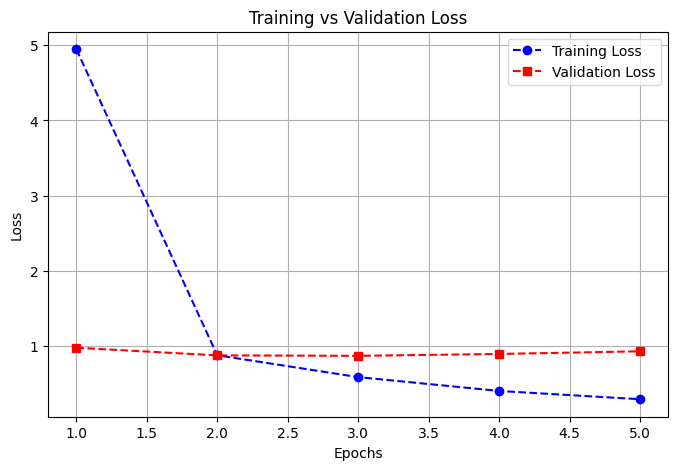

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data from your logs
epochs = [1, 2, 3, 4, 5]
train_loss = [4.947, 0.8803, 0.5899, 0.406, 0.2961]
val_loss = [0.9801, 0.8788, 0.8727, 0.8976, 0.9326]

# Plotting Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='dashed', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s', linestyle='dashed', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


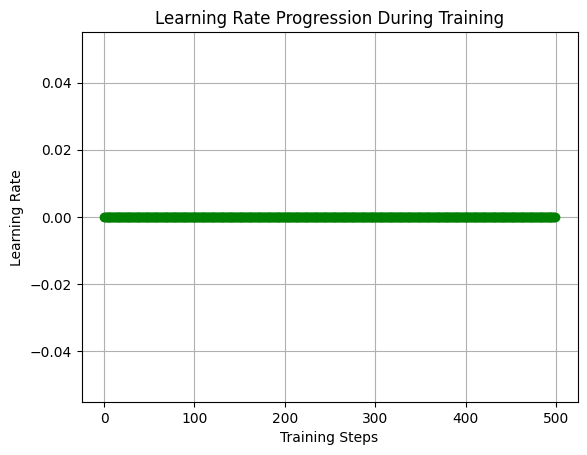

In [ ]:
import matplotlib.pyplot as plt

lr_values = []

for step in range(trainer.state.global_step):
    for param_group in trainer.optimizer.param_groups:
        lr_values.append(param_group['lr'])

plt.plot(lr_values, marker='o', linestyle='dashed', color='green')
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Progression During Training")
plt.grid(True)
plt.show()


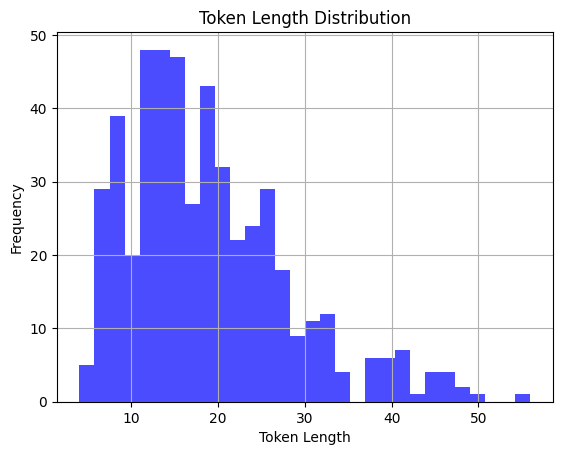

In [ ]:
import matplotlib.pyplot as plt

# Extract token lengths from dataset
token_lengths = [len(tokenizer.tokenize(text)) for text in dataset["src"]]

# Plot distribution
plt.hist(token_lengths, bins=30, color='blue', alpha=0.7)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Token Length Distribution")
plt.grid(True)
plt.show()


In [ ]:
import torch
from transformers import MBartTokenizer

# Load tokenizer and trained model
tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-50")  # Replace with your model
model = model.to("cuda" if torch.cuda.is_available() else "cpu")  # Ensure model is on GPU/CPU

# Define input text
input_text = ["Hello, how are you?", "This is a test sentence."]

# Tokenize input
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
inputs = {key: value.to(device) for key, value in inputs.items()}

# Generate predictions
with torch.no_grad():
    output_ids = model.generate(**inputs, max_length=128, num_beams=5, early_stopping=True)

# Decode output tokens into text
decoded_outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

print(decoded_outputs)


tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


['हेलो, तुम कैसी हौय?', 'यो टेस्ट वाक्य है।']


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Get actual labels and predictions
all_preds = []
all_labels = []

for example in eval_dataset:  # Process examples one by one
    inputs = tokenizer(example["src"], return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    labels = tokenizer(example["tgt"], return_tensors="pt", padding="max_length", truncation=True, max_length=128)["input_ids"]

    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move input to GPU if available

    with torch.no_grad():
        output_ids = model.generate(**inputs, max_length=128, num_beams=5, early_stopping=True)

    # Convert predictions to label indices
    pred_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    true_text = tokenizer.decode(labels[0], skip_special_tokens=True)

    # Append to lists (convert text labels to indices for confusion matrix)
    all_preds.append(pred_text)
    all_labels.append(true_text)

# Convert text labels to numerical indices
unique_labels = list(set(all_labels + all_preds))  # Get all unique labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

y_true = [label_to_index[label] for label in all_labels]
y_pred = [label_to_index[label] for label in all_preds]



/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2324 (\N{DEVANAGARI LETTER AU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/py

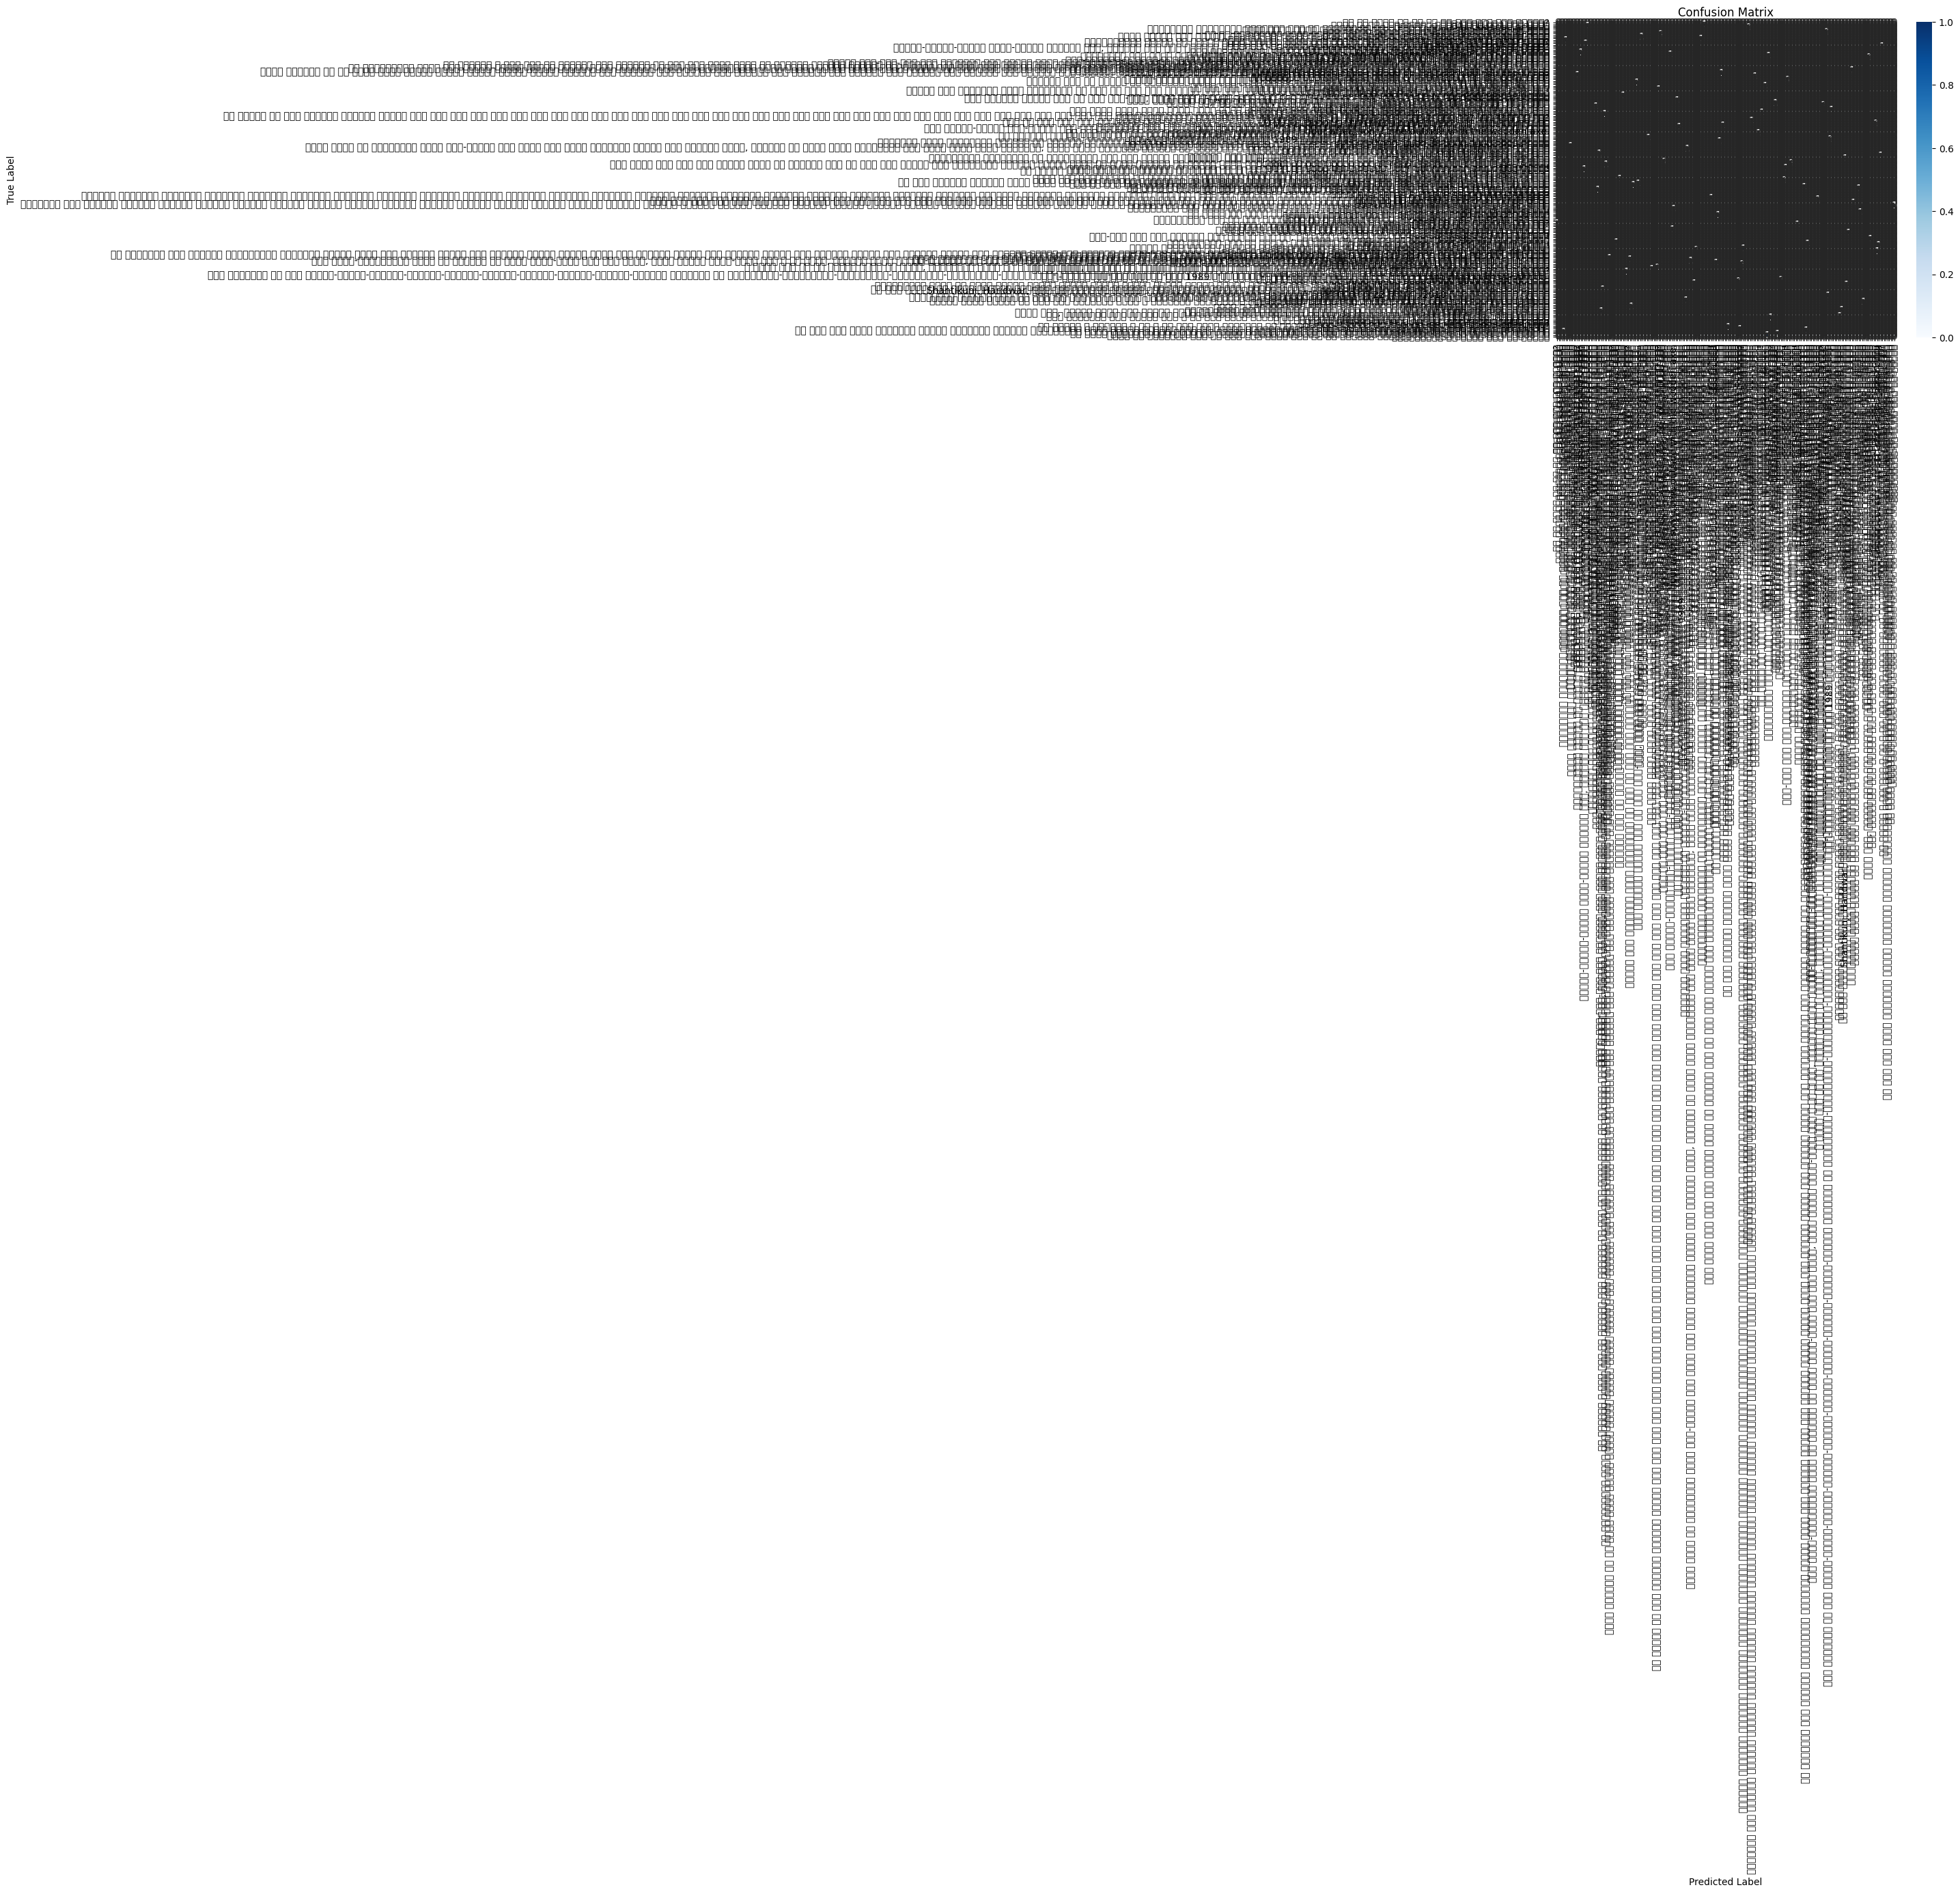

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
